In [1]:
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('''C:/Users/cayde/Desktop/Research/delay-optimizer''')
from DelayEffects.Analyzer import Analyzer

In [2]:
# Initialize
loss_name = 'Zakharov'
zak2d = Analyzer(2, loss_name)
zak10d = Analyzer(10, loss_name)
zak100d = Analyzer(100, loss_name)
zak1000d = Analyzer(1000, loss_name)
zak10000d = Analyzer(10000, loss_name)

# Helper Functions

In [3]:
# Helper Functions
def fill_table(analyzer, max_L, num_points, partials=[0.2, 0.5, 0.8], same_points=False):
    # Initialize data array
    data = np.nan*np.zeros((4, 3 + 2*len(partials)))
    
    # Initialize column and index names
    columns = ['No Change', 'On/Off', 'Decaying']
    new_cols = []
    for percent in partials:
        columns.append("Partial ({}%)".format(percent*100))
        new_cols.append("Stochastic Partial ({}%)".format(percent*100))
    columns += new_cols
    indices = ['Constant', 'Periodic', 'Stochastic', 'Undelayed']
    
    # Use the same initial points for all calculations?
    if same_points is True:
        analyzer.initialize_points(num_points, 'random')
        gen_points = False
    
    # Perform the computations
    # Constant
    data[0,0] = test(analyzer, "constant", "same", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[0,1] = test(analyzer, "constant", "binary", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[0,2] = test(analyzer, "constant", "decay", max_L, num_points, print_vals=False, gen_points=gen_points)
    for i, percent in enumerate(partials):
        data[0,3+i] = test(analyzer, "constant", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[0,3+i+len(partials)] = test(analyzer, "constant", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Periodic
    data[1,0] = test(analyzer, "periodic", "same", max_L, num_points, print_vals=False)
    data[1,1] = test(analyzer, "periodic", "binary", max_L, num_points, print_vals=False)
    data[1,2] = test(analyzer, "periodic", "decay", max_L, num_points, print_vals=False)
    for i, percent in enumerate(partials):
        data[1,3+i] = test(analyzer, "periodic", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[1,3+i+len(partials)] = test(analyzer, "periodic", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Stochastic
    data[2,0] = test(analyzer, "stochastic", "same", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[2,1] = test(analyzer, "stochastic", "binary", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[2,2] = test(analyzer, "stochastic", "decay", max_L, num_points, print_vals=False, gen_points=gen_points)
    for i, percent in enumerate(partials):
        data[2,3+i] = test(analyzer, "stochastic", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[2,3+i+len(partials)] = test(analyzer, "stochastic", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Undelayed
    analyzer.calculate_save_values(False, save_grad=False, save_state=False, save_iters=False, break_opt=False)
    data[3,0] = np.mean(analyzer.final_losses)
        
    # Create the dataframe
    dataframe = pd.DataFrame(data, index=indices, columns=columns)
    dataframe.style.set_caption("Rosenbrock Function | n={} | Max Delay is {}".format(analyzer.n, analyzer.max_L))
    
    return dataframe
    
        
def test(analyzer, test_type, dist_type, max_L, num_points, stochastic_partials=False, percent=0.5, 
         print_vals=True, gen_points=True):
    # Initialize
    n = analyzer.n
    maxiter = analyzer.maxiter
    num_delays = 1000   # How many iterations to delay for binary distributions
    random = False
    
    if test_type == 'constant':
        if dist_type == 'same':
            # Delays are all equal to max_L in every dimension for the full number of iterations
            print_str = "No Change Constant"
            D = max_L * np.ones(n, dtype=int)
            D = [D]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays are all equal to max_L in every dimension, but delays are turned off after 1000 iterations
            print_str = "On/Off Constant"
            D = max_L * np.ones(n, dtype=int)
            D = [D]
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays start with max_L in every dimension and decrease over time
            print_str = "Decaying Constant"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                D.append(D_s[i]*np.ones(n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'partial':
            # Delays are all equal to max_L, but only in some of the dimensions (others are undelayed)
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                # Choose which dimensions are delayable stochastically each iteration
                print_str = "{} Stochastic Partial Constant".format(percent)
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    for dim in range(n):
                        if np.random.random() < percent:
                            iter_delay[dim] = max_L
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Constant".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = max_L
                D = [D_s]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
            
    elif test_type == 'periodic':
        if dist_type == 'same':
            # Delays alternate over time between max_L and 0 (no delay) for the full number of iterations
            print_str = "No Change Periodic"
            D = [max_L*np.ones(n, dtype=int), np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays alternate over time between max_L and 0, and delays are turned off after 1000 iterations
            print_str = "On/Off Periodic"
            D = [max_L*np.ones(n, dtype=int), np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays alternate over time between max_L and 0, but max_L decreases over time
            print_str = "Decaying Periodic"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                if i % 2 == 0:
                    D.append(D_s[i]*np.ones(n, dtype=int))
                else:
                    D.append(np.zeros(n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'partial':
            # Delays alternate over time between max_L and 0, but only in some of the dimensions (others are undelayed)
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                print_str = "{} Stochastic Partial Periodic".format(percent)
                # Choose which dimensions are delayable stochastically each iteration
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    if i % 2 == 0:
                        for dim in range(n):
                            if np.random.random() < percent:
                                iter_delay[dim] = max_L
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Periodic".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = max_L
                D = [D_s, np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
            
    elif test_type == 'stochastic':
        if dist_type == 'same':
            # Delays are determined stochastically in every dimension for the full number of iterations
            print_str = "No Change Stochastic"
            D = None
            random = True
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays are determined stochastically in every dimension, and are turned off after 1000 iterations
            print_str = "Binary Stochastic"
            D = None
            random = True
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays are determined stochastically in every dimension, but max_L decreases over time
            print_str = "Decaying Stochastic"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                D.append(np.random.randint(0, D_s[i]+1, size=n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L) 
        elif dist_type == 'partial':
            # Delayed dimensions are done with normal stochastic delays, and others dimensions are undelayed
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                # Choose which dimensions are delayable stochastically each iteration
                print_str = "{} Stochastic Partial Stochastic".format(percent)
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    for dim in range(n):
                        if np.random.random() < percent:
                            iter_delay[dim] = np.random.randint(0, max_L+1)
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Stochastic".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = np.random.randint(0, max_L+1,num_delay_dims)
                D = [D_s]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
    else:
        raise ValueError("{} is not a valid test type".format(test_type))
    
    # Perform the optimization
    if gen_points is True:
        analyzer.initialize_points(num_points, 'random')
    analyzer.calculate_save_values(True, D=D, random=random, save_grad=False, save_state=False, 
                                   save_iters=False, break_opt=False)
    
    if print_vals is True:
        print("{} Delay - Max Delay of {}\nAverage Loss: {}".format(print_str, max_L, np.mean(analyzer.del_final_losses)), 
              end='\n\n')
        
    return np.mean(analyzer.del_final_losses)

#  2 Dimensional Grid Loss Test

### Undelayed Optimal Parameters Test

C:\Users\cayde\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


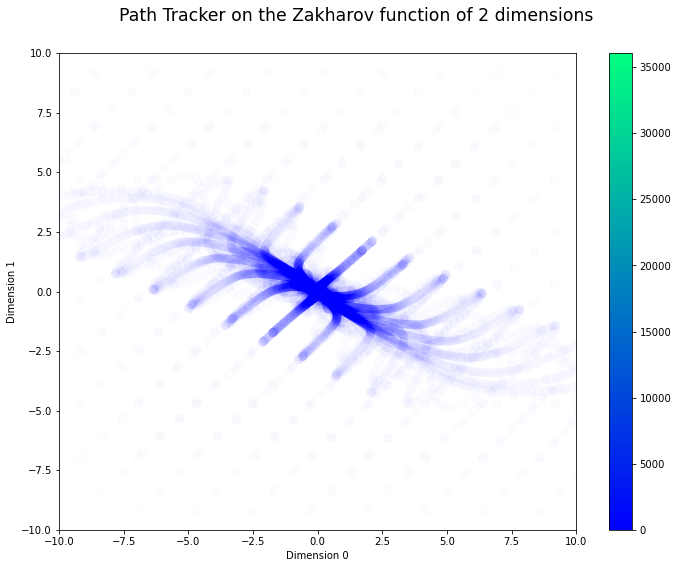

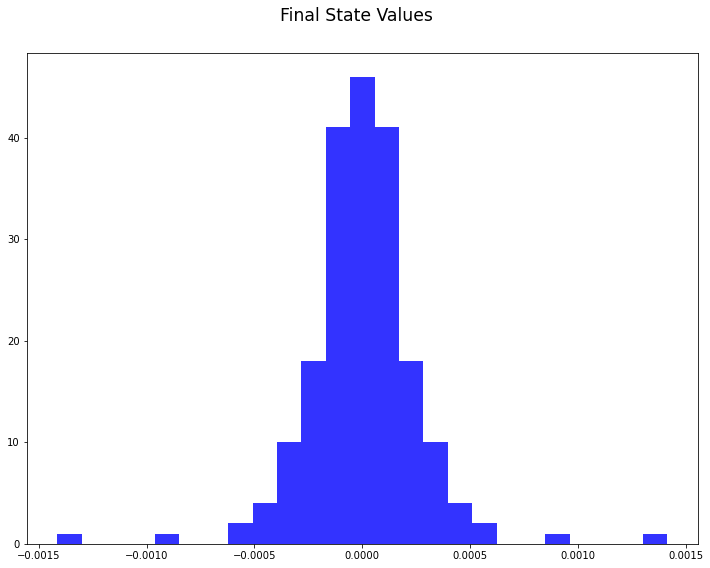

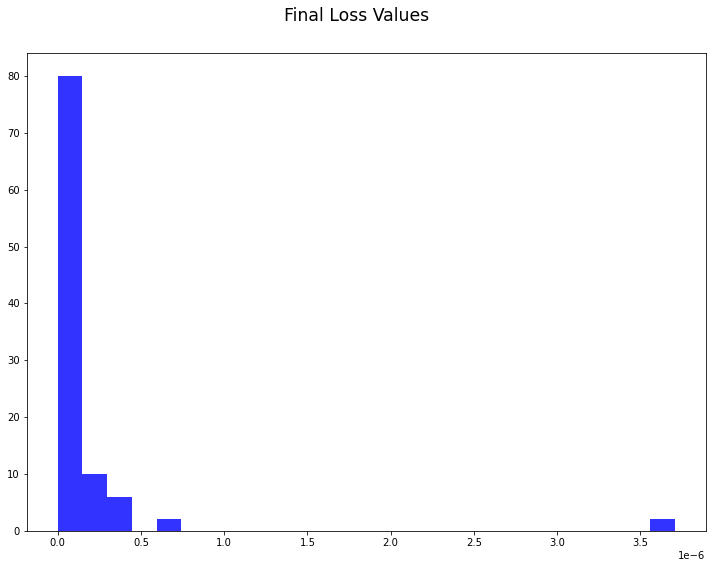

Minimum Loss: 4.2815562207746403e-10
Mean Loss: 1.6859851205367488e-07
Median Loss: 4.056858920137986e-08


In [15]:
plots = [(False, 'path', 'loss'), (False, 'finals', 'state'), (False, 'finals', 'loss')]
zak2d.optimize(10, 'grid', False, plots, range_grid=[-10.,10.], clear_data=True)

### Delayed Optimal Parameters Test

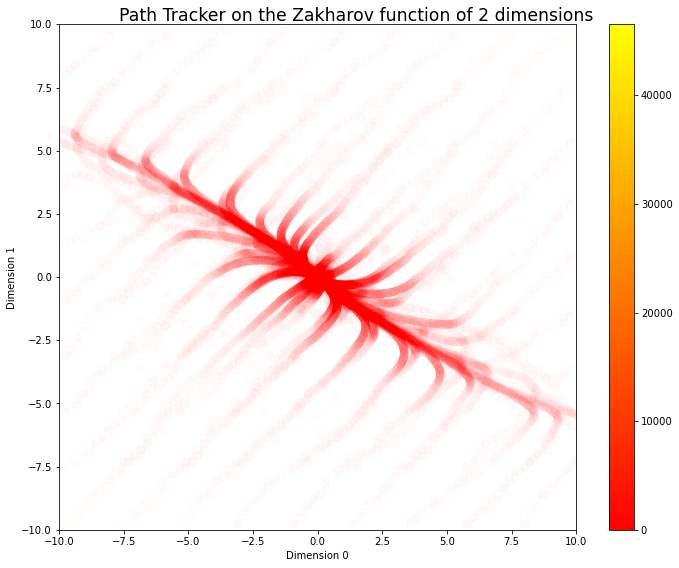

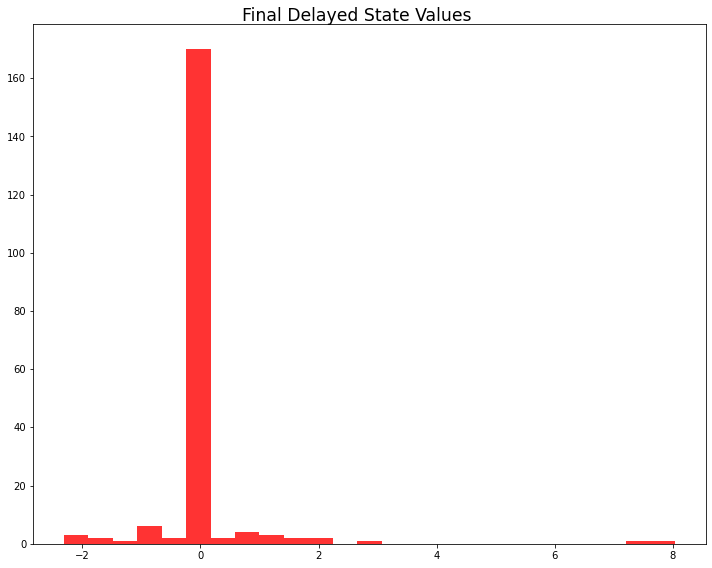

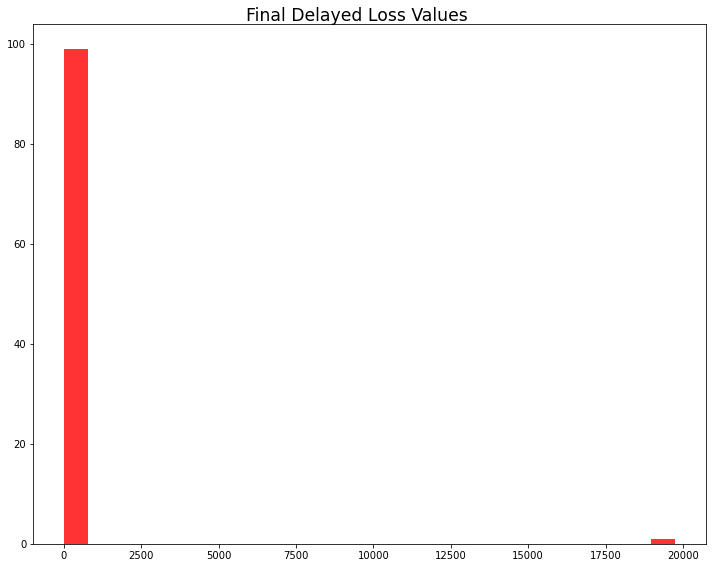

Minimum Delayed Loss: 5.136855268517966e-10
Mean Delayed Loss: 197.95269372129803
Median Delayed Loss: 1.9239474277494803e-06


In [6]:
plots = [(True, 'path', 'loss'), (True, 'finals', 'state'), (True, 'finals', 'loss')]
zak2d.optimize(10, 'grid', True, plots, range_grid=[-10.,10.], clear_data=True)

# 1000 Dimensions Test

In [9]:
plots = [('both', 'path', 'loss'), ('both', 'finals', 'state'), ('both', 'finals', 'loss')]

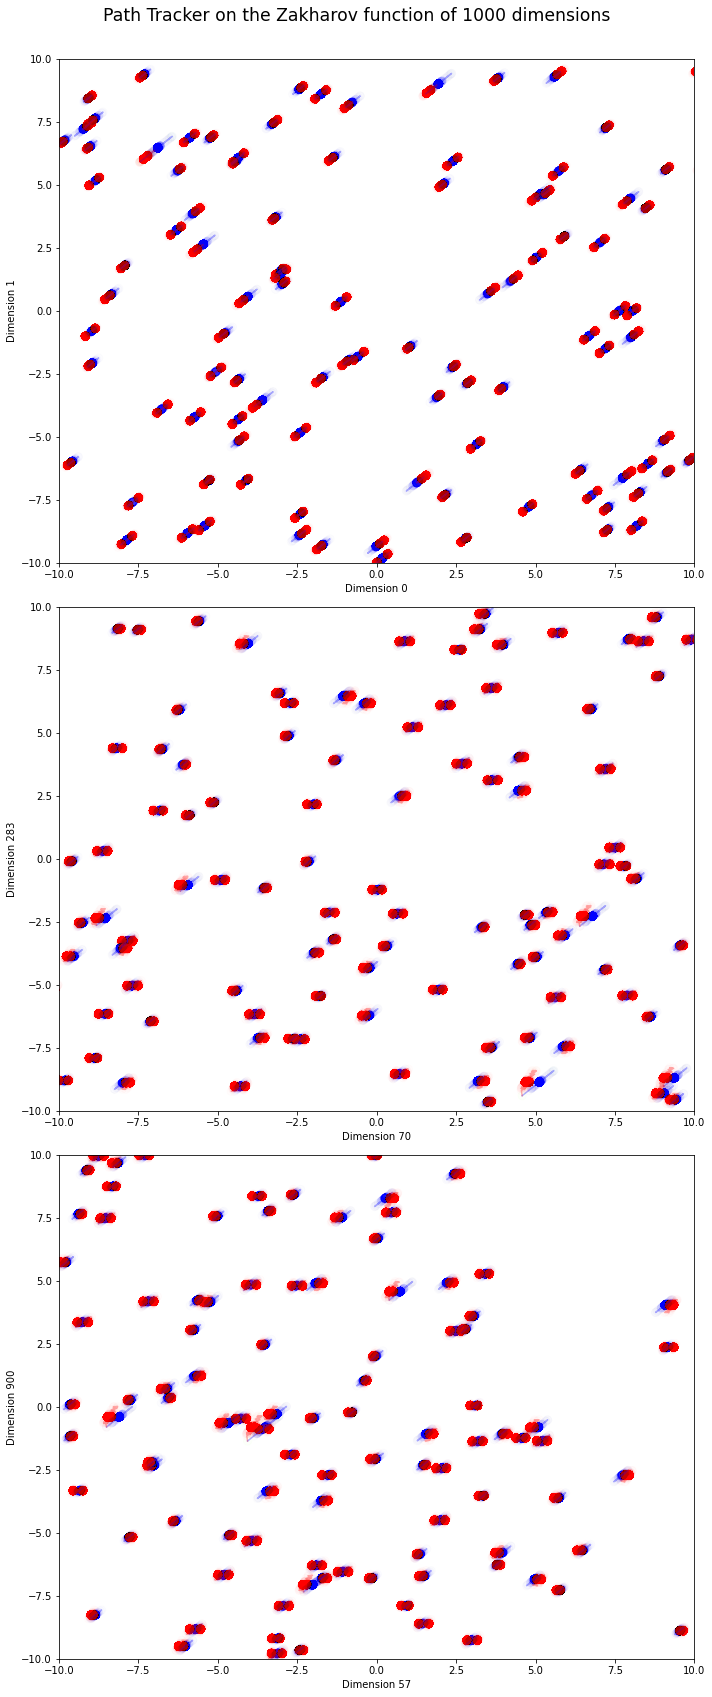

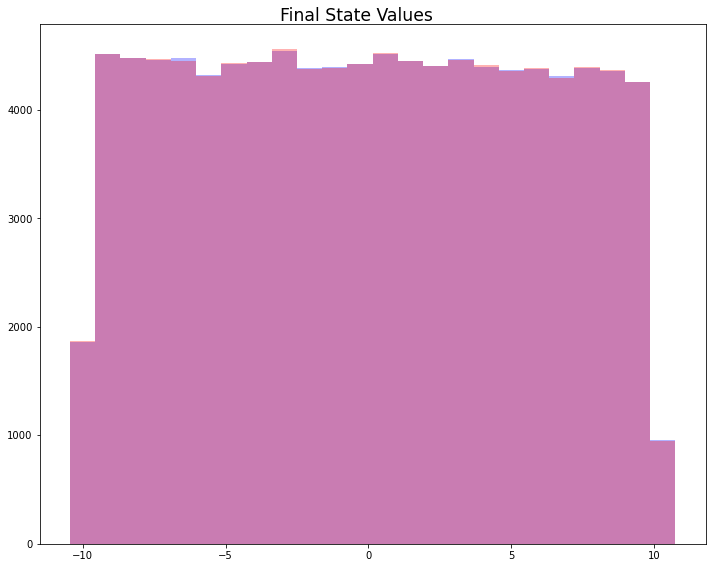

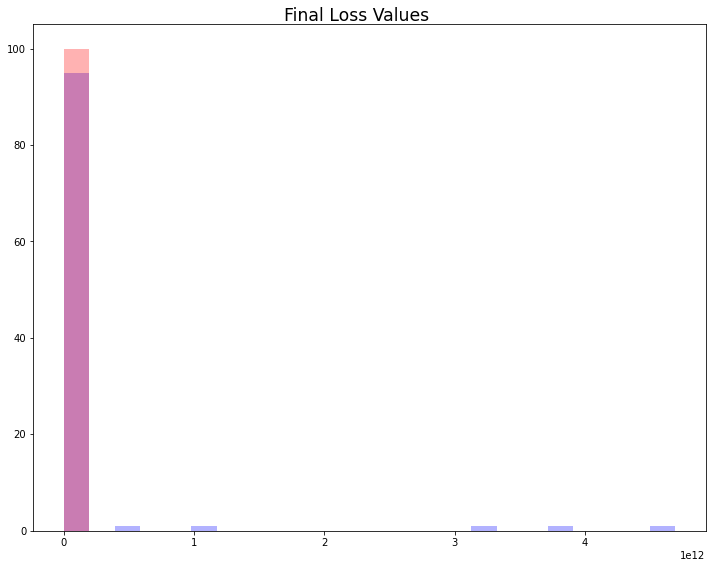

Minimum Loss: 35948.375571372664
Mean Loss: 137934671180.32
Median Loss: 86038659.0092532
Minimum Delayed Loss: 31861.426526604126
Mean Delayed Loss: 1061891877.8646468
Median Delayed Loss: 184604172.16323477


In [10]:
D_s = np.zeros(1000,dtype=int)
D_s[0:100] = 1
D = [D_s]
zak1000d.optimize(100, 'random', 'both', plots, time_plot=True, plot_dims=[(0,1),(70,283),(57,900)], colorbar=False, random=False, D=D)

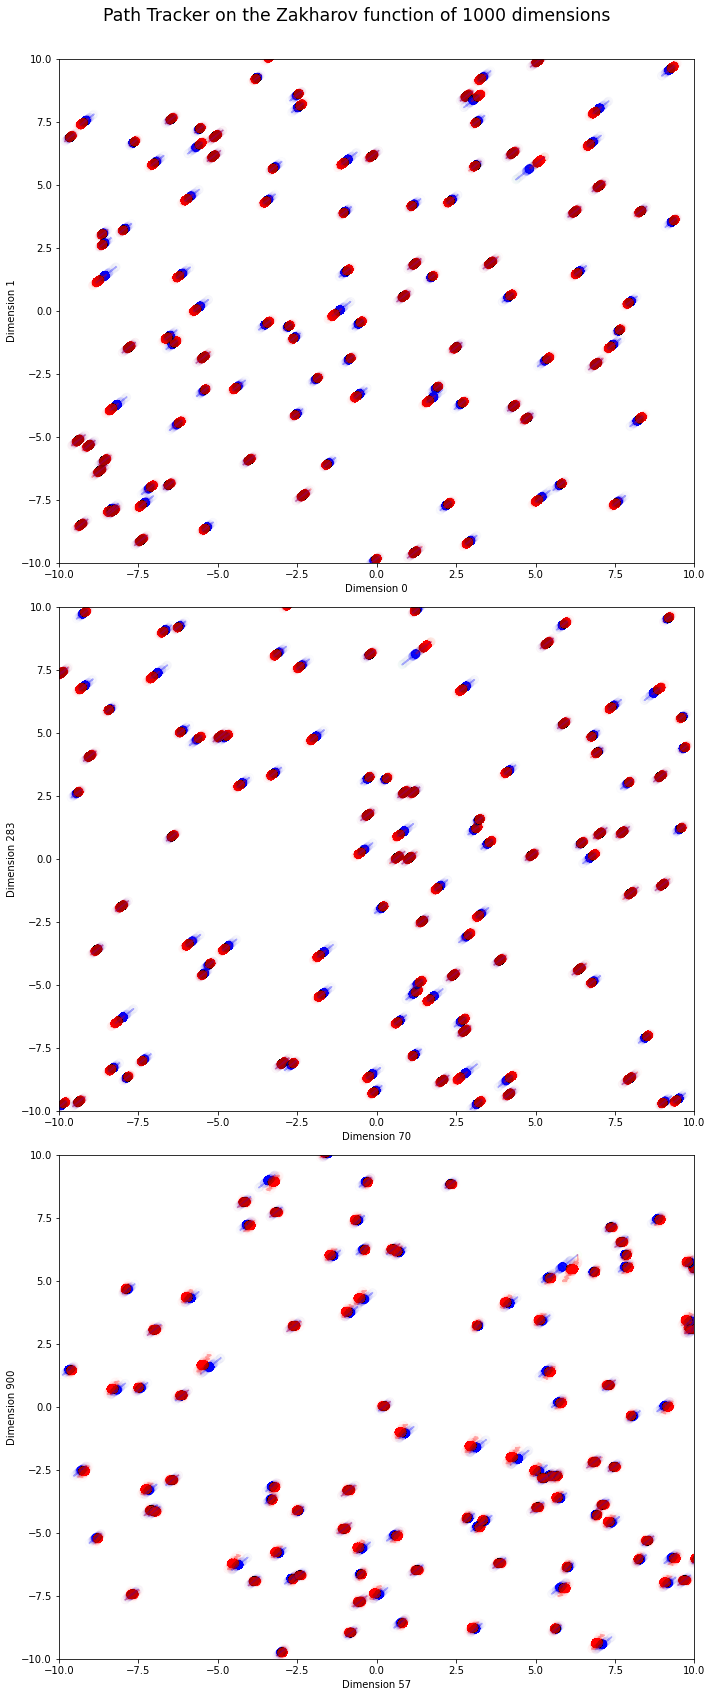

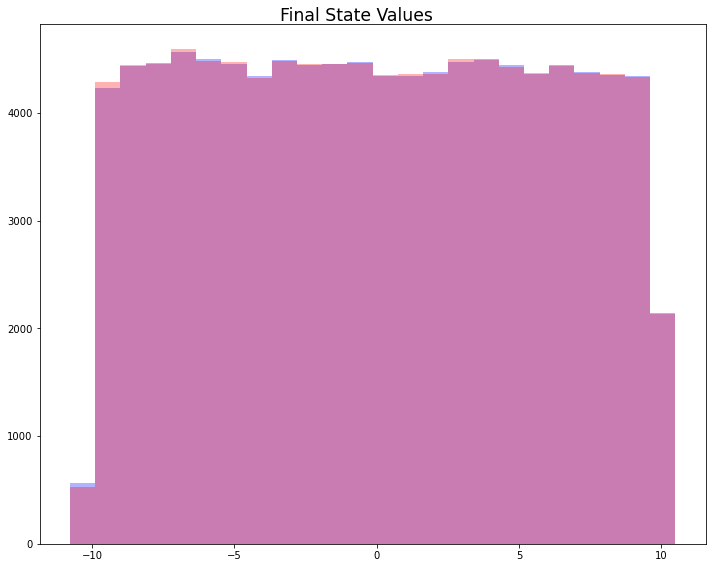

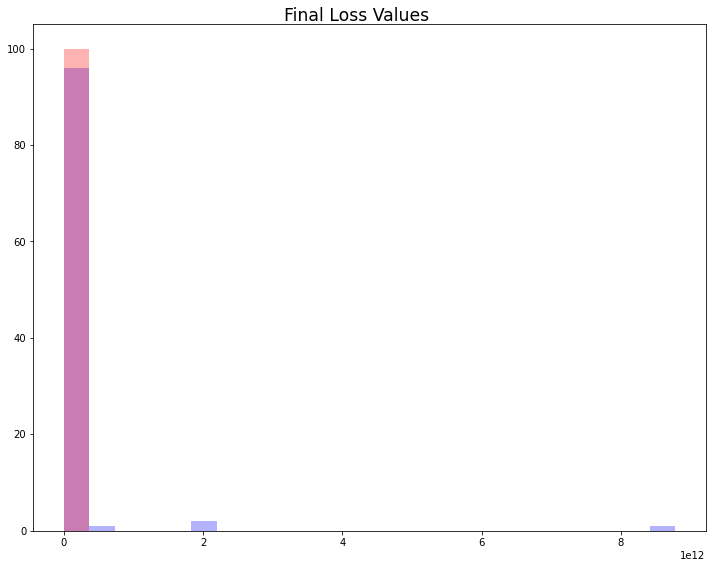

Minimum Loss: 104372.67831742702
Mean Loss: 143909642553.6542
Median Loss: 80822291.3811296
Minimum Delayed Loss: 1440740.8777297027
Mean Delayed Loss: 1297823892.6590474
Median Delayed Loss: 158402465.15986323


In [11]:
D_s = np.zeros(1000,dtype=int)
D_s[0:500] = 1
D = [D_s]
zak1000d.optimize(100, 'random', 'both', plots, time_plot=True, plot_dims=[(0,1),(70,283),(57,900)], colorbar=False, random=False, D=D)

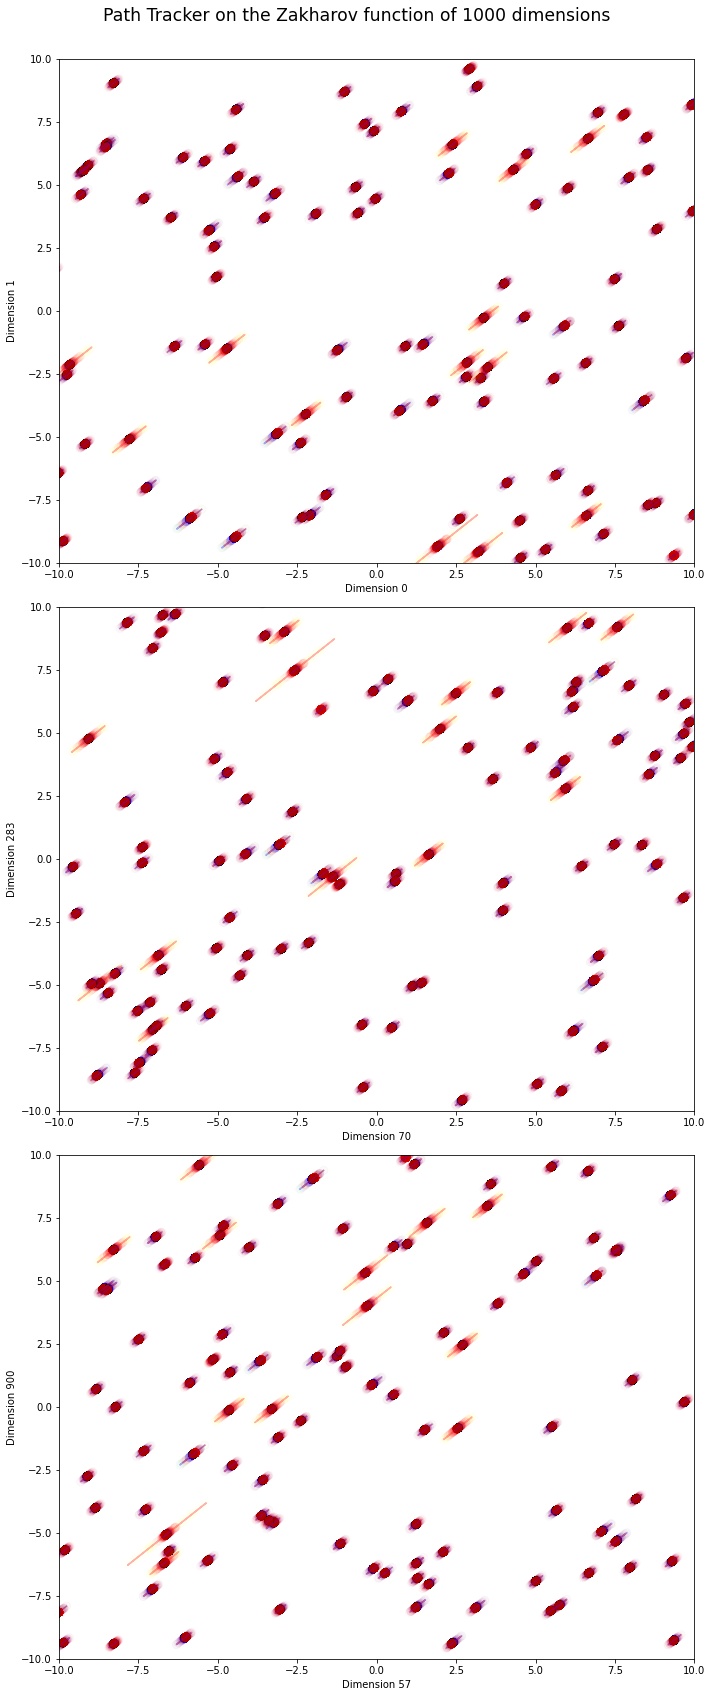

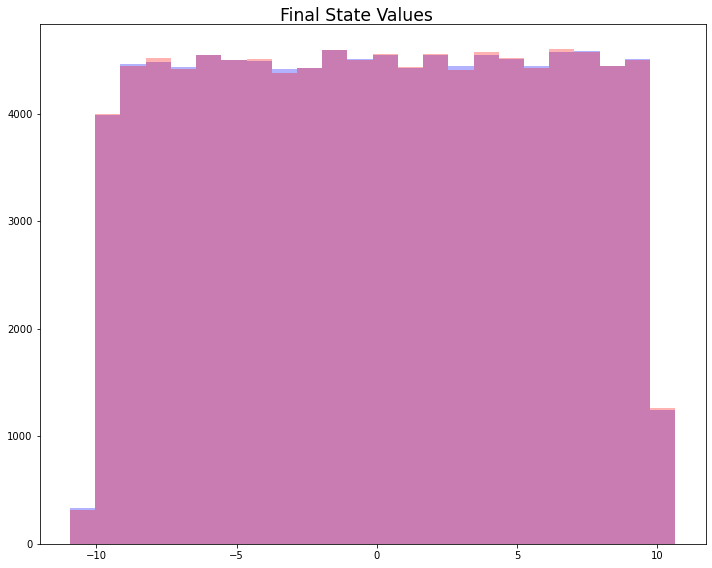

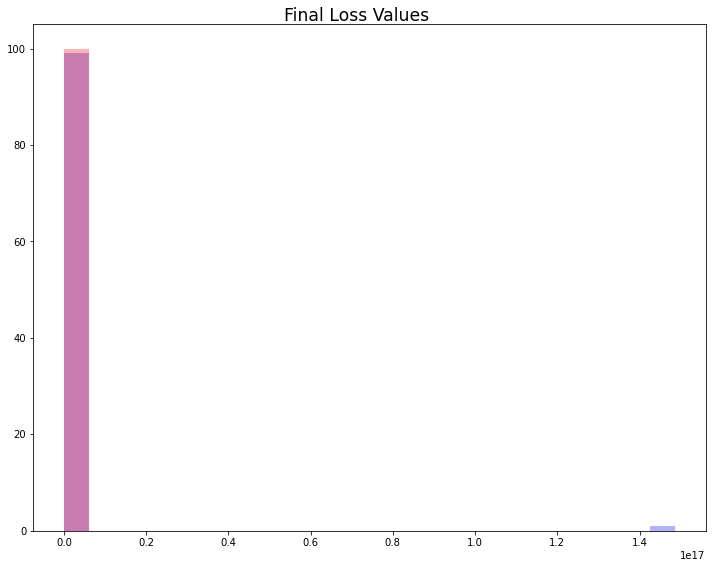

Minimum Loss: 62628.588686238734
Mean Loss: 1486340470980757.5
Median Loss: 81736929.924649
Minimum Delayed Loss: 33687474.96387138
Mean Delayed Loss: 63435766209.64988
Median Delayed Loss: 418687591.5110263


In [12]:
D_s = np.zeros(1000,dtype=int)
D_s[:950] = 1
D = [D_s]
zak1000d.optimize(100, 'random', 'both', plots, time_plot=True, plot_dims=[(0,1),(70,283),(57,900)], colorbar=False, random=False, D=D)

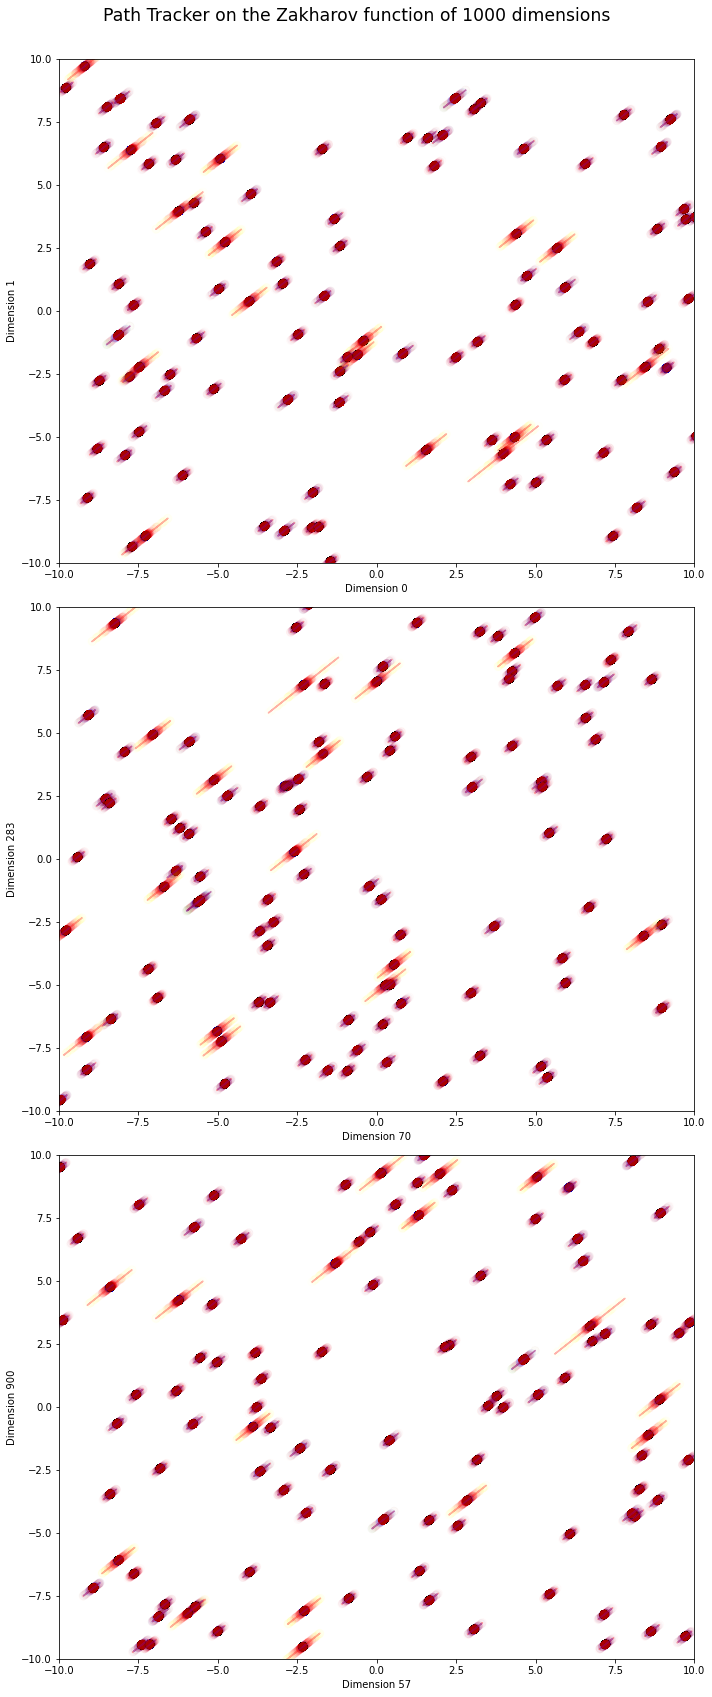

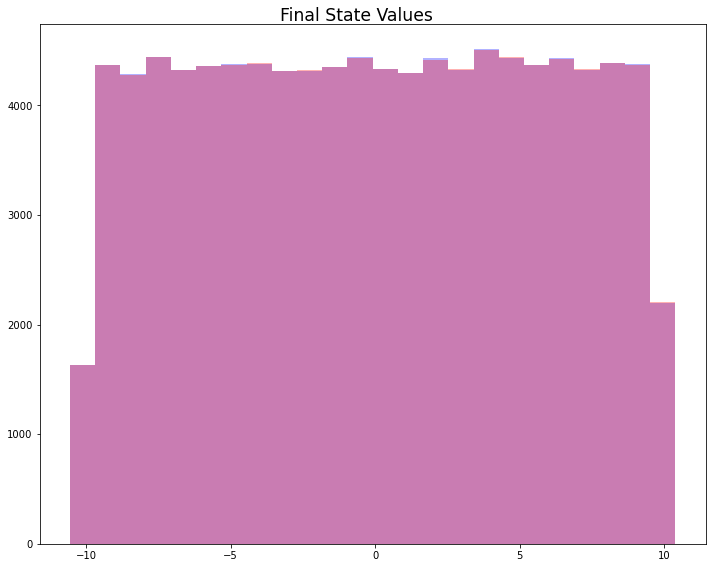

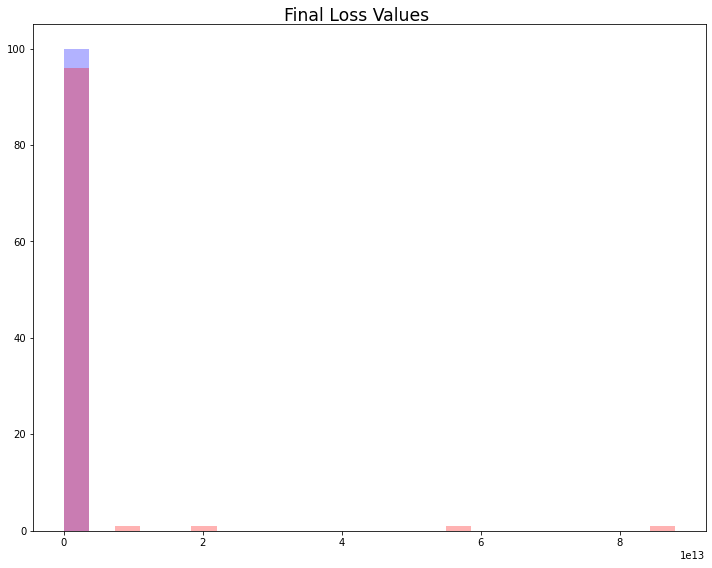

Minimum Loss: 5860799.435107303
Mean Loss: 35528870991.16592
Median Loss: 81340726.7240769
Minimum Delayed Loss: 181603572.53369233
Mean Delayed Loss: 1848181624189.054
Median Delayed Loss: 1754967860.8619733


In [13]:
D_s = np.ones(1000,dtype=int)
D = [D_s]
zak1000d.optimize(100, 'random', 'both', plots, time_plot=True, plot_dims=[(0,1),(70,283),(57,900)], colorbar=False, random=False, D=D)

# Basins of Attraction (2d)

In [5]:
plots = [('both', 'basin', 'loss'),('both', 'basin', 'iters')]
zak2d.optimize(100, 'grid', 'both', plots, contour_plot=True)

KeyboardInterrupt: 

In [ ]:
plots = [('both', 'basin', 'loss'),('both', 'basin', 'iters')]
zak2d.optimize(100, 'grid', 'both', plots, contour_plot=True)

# Delay Tests

In [9]:
fill_table(zak2d, 5, 100, partials=[0.5], same_points=True)

,No Change,On/Off,Decaying,Partial (50.0%),Stochastic Partial (50.0%)
Constant,4.217587e+02,6.910659e-05,0.000178,0.275022,3.066254e-05
Periodic,9.619169e+00,5.708432e-13,0.000010,0.619502,1.167007e-11
Stochastic,4.284612e+01,3.547833e-05,0.000005,0.256856,1.113225e+00
Undelayed,8.292690e-13,NaN,NaN,NaN,NaN


In [10]:
fill_table(zak10d, 5, 100, same_points=True)

,No Change,On/Off,Decaying,Partial (20.0%),Partial (50.0%),Partial (80.0%),Stochastic Partial (20.0%),Stochastic Partial (50.0%),Stochastic Partial (80.0%)
Constant,380.267103,189.026425,210.749821,149.132832,182.023054,263.349946,179.748976,189.978861,236.718054
Periodic,416.055459,173.083264,196.976780,162.754104,192.057743,276.492913,168.321197,194.475342,212.209916
Stochastic,221.569335,177.993503,183.507342,158.030845,171.294874,203.569603,171.427970,190.332197,200.406674
Undelayed,144.585382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
fill_table(zak100d, 5, 100, same_points=True)

,No Change,On/Off,Decaying,Partial (20.0%),Partial (50.0%),Partial (80.0%),Stochastic Partial (20.0%),Stochastic Partial (50.0%),Stochastic Partial (80.0%)
Constant,4.510672e+07,35947.450013,131568.032381,2.342248e+06,3.923200e+07,3.074238e+07,5454.302647,16375.350231,460641.747517
Periodic,1.507394e+08,7112.876323,38389.725234,2.363217e+06,6.402122e+07,1.407307e+08,4951.994359,8221.028574,21287.661038
Stochastic,6.660881e+05,49299.675847,14750.819151,2.690104e+04,1.292426e+05,2.325072e+07,4891.261760,7399.451918,12286.323786
Undelayed,8.921277e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
fill_table(zak1000d, 5, 100, same_points=True)

,No Change,On/Off,Decaying,Partial (20.0%),Partial (50.0%),Partial (80.0%),Stochastic Partial (20.0%),Stochastic Partial (50.0%),Stochastic Partial (80.0%)
Constant,1.640152e+15,5.479599e+12,1.475960e+13,3.718906e+14,6.070856e+14,1.104553e+14,7.714604e+08,1.382408e+09,3.239043e+13
Periodic,1.106985e+15,1.095146e+10,7.888909e+10,3.779154e+14,1.208216e+15,1.349433e+15,1.981431e+09,4.890116e+09,1.137146e+10
Stochastic,1.642178e+13,3.096186e+12,3.462519e+12,3.318095e+12,3.006431e+19,3.463419e+15,6.871905e+08,4.103515e+08,3.587531e+11
Undelayed,1.122904e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
fill_table(zak10000d, 5, 100, same_points=True)

,No Change,On/Off,Decaying,Partial (20.0%),Partial (50.0%),Partial (80.0%),Stochastic Partial (20.0%),Stochastic Partial (50.0%),Stochastic Partial (80.0%)
Constant,4.168216e+21,3.747185e+20,6.935330e+20,2.498169e+22,4.525879e+23,9.843157e+22,1.863532e+17,9.516012e+16,5.044255e+21
Periodic,3.951451e+23,2.586005e+18,7.504178e+18,1.959132e+22,3.128693e+23,1.502916e+23,4.509154e+17,1.141330e+18,2.699017e+18
Stochastic,1.653215e+21,2.540425e+20,4.817944e+20,2.106393e+20,1.364289e+20,3.087720e+24,1.305605e+17,2.288396e+16,1.103235e+19
Undelayed,3.318116e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Chaotic System test

In [19]:
def chaos_test(analyzer, eps=1e-8, max_L=1, given=None, num_delays=1000):
    # Initialize
    n = analyzer.n
    low, high = analyzer.range_grid

    # Set or unpack initial values
    if given is None:
        x_init = np.random.uniform(low, high, size=n)
        x_init_err = np.ones(n)*eps + x_init
    else:
        x_init, x_init_err = given

    # Find paths constant
    analyzer.optimize(1, 'given', True, plots=[[True, 'path', 'loss']], points=[x_init, x_init_err], 
                      max_L=max_L, D=[np.ones(n, dtype=int)], random=False, time_plot=True, 
                      clear_data=False, num_delays=num_delays, break_opt=False)

    # Plot the error over time
    fig = plt.figure(figsize=(10,8))
    x1 = analyzer.del_time_series[0]
    x2 = analyzer.del_time_series[1]
    plt.semilogy(np.linalg.norm(x1 - x2, axis=1))
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.title("Error of closely spaced points over time")
    plt.show()
    
    analyzer.clear()

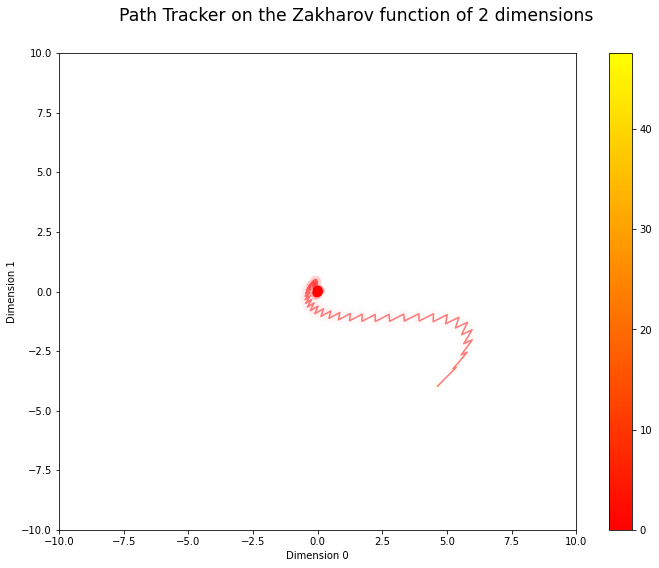

Minimum Delayed Loss: 1.1157706272135431e-63
Mean Delayed Loss: 1.1157775523724696e-63
Median Delayed Loss: 1.1157775523724696e-63


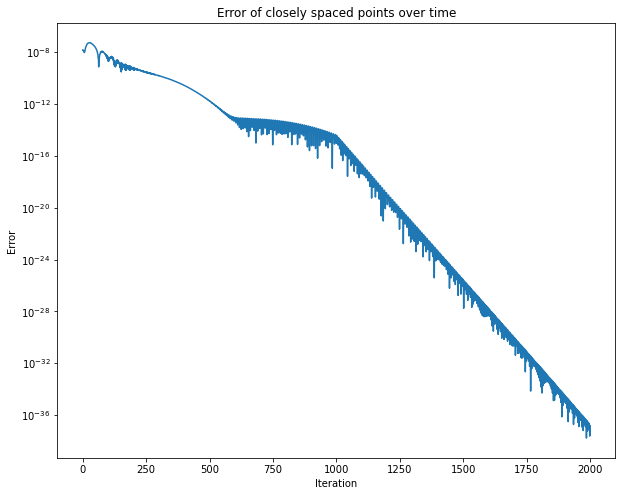

In [20]:
chaos_test(zak2d)

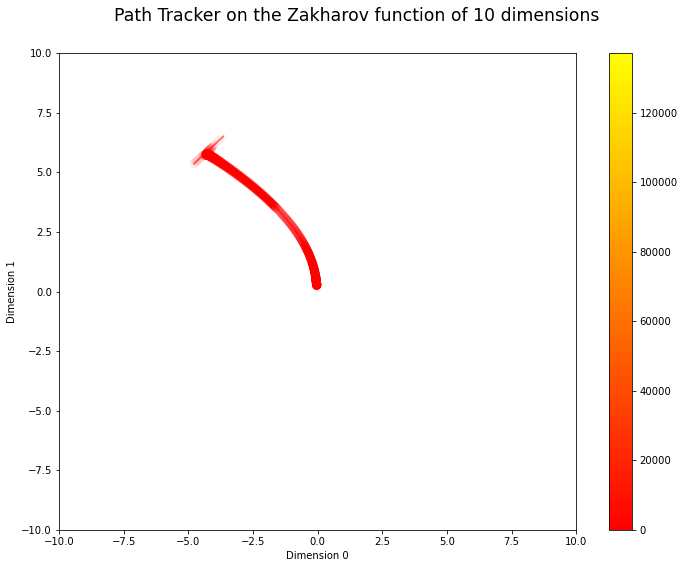

Minimum Delayed Loss: 33.27743353788207
Mean Delayed Loss: 33.277434259394305
Median Delayed Loss: 33.277434259394305


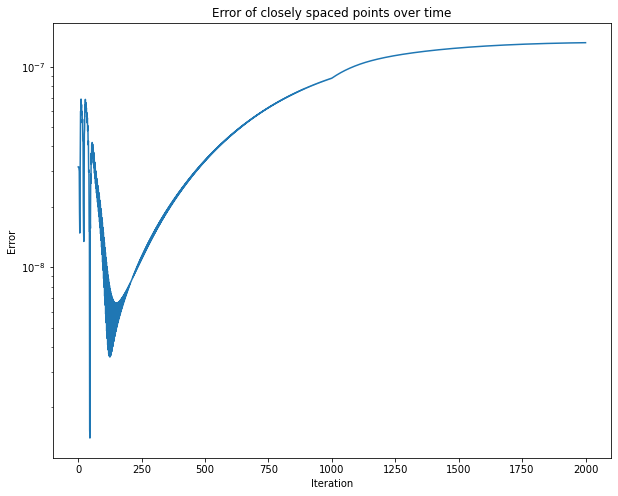

In [21]:
chaos_test(zak10d)

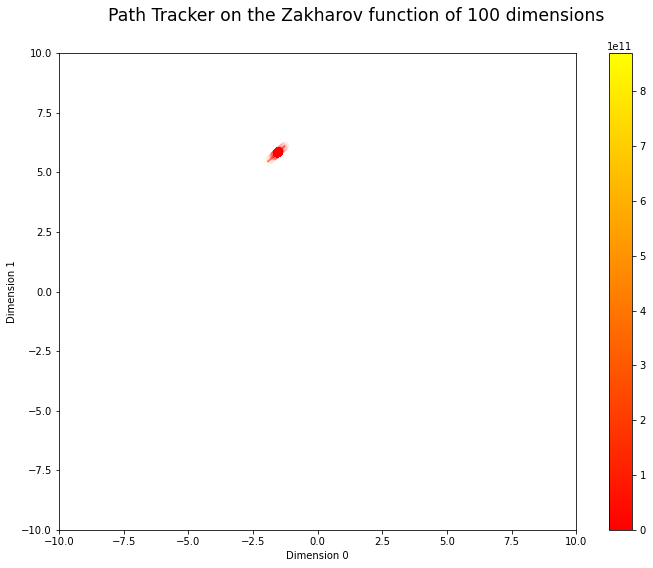

Minimum Delayed Loss: 3264.9747978195614
Mean Delayed Loss: 3264.9747987364462
Median Delayed Loss: 3264.9747987364462


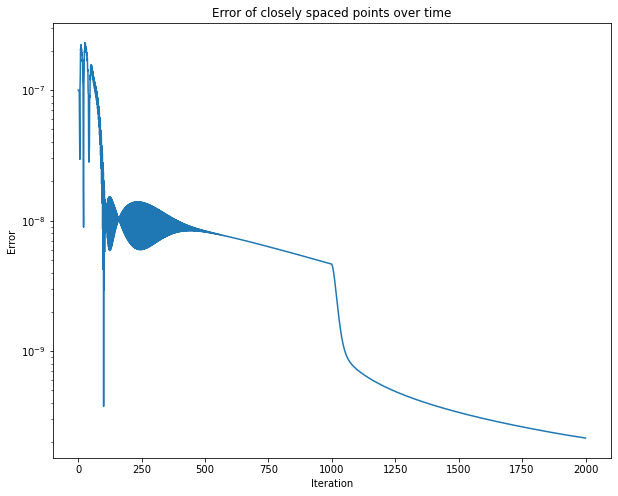

In [22]:
chaos_test(zak100d)

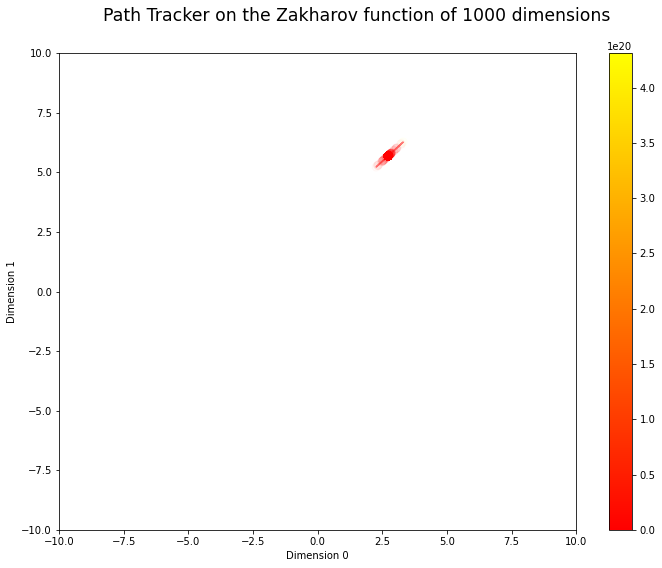

Minimum Delayed Loss: 8330392814.640388
Mean Delayed Loss: 8330394580.166288
Median Delayed Loss: 8330394580.166288


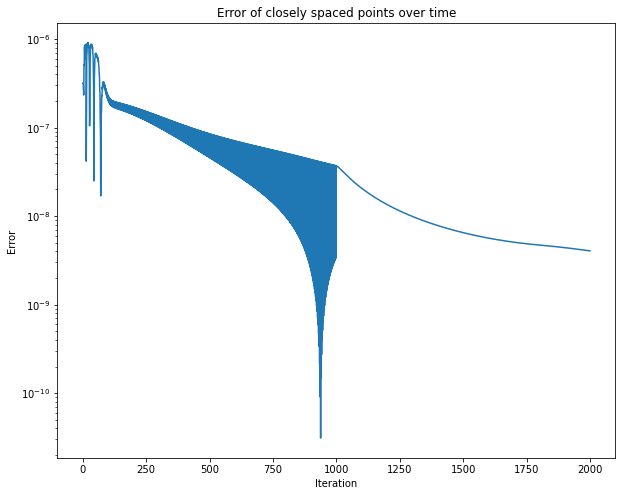

In [23]:
chaos_test(zak1000d)

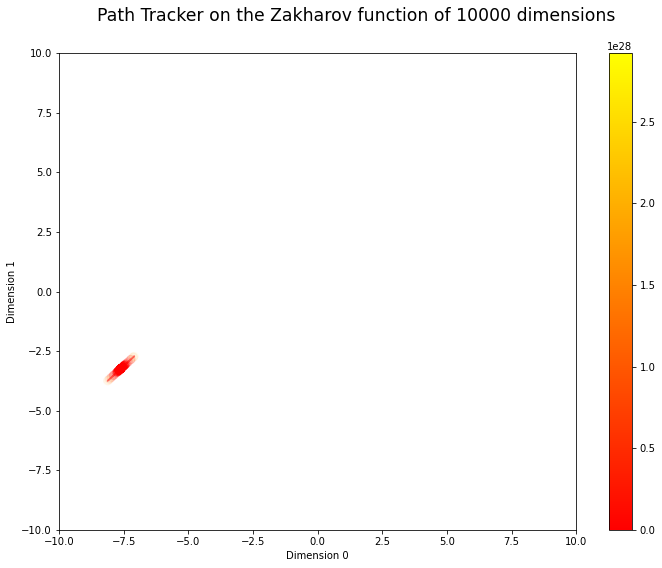

Minimum Delayed Loss: 2.177342031467887e+18
Mean Delayed Loss: 2.1773435957605276e+18
Median Delayed Loss: 2.1773435957605276e+18


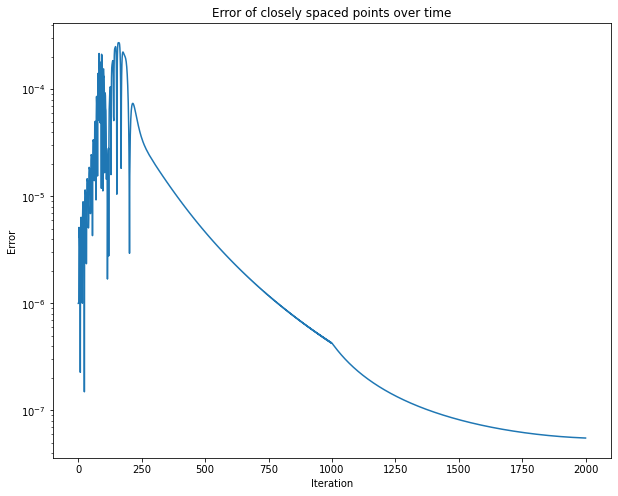

In [24]:
chaos_test(zak10000d)